# Predcition of Hospital Admission Related to Otitis Media 

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis media (otmedia).

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'otmedia_date_'+str(i), 'otmedia_ab_date_'+str(i), 'otmedia_ab_type_'+str(i),
                   'incdt_otmedia_date_'+str(i), 'admitted_otmedia_date_'+str(i), 'sgss_gp_cov_otmedia_date_'+str(i)]]
    
    #drop rows with no otmedia reord
    datum = datum[datum['otmedia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with otmedia_i
    datum = datum[datum['sgss_gp_cov_otmedia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'otmedia_date_'+str(i): 'otmedia_date', 'otmedia_ab_date_'+str(i): 'otmedia_ab_date', 
                           'otmedia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_otmedia_date_'+str(i): 'incdt_otmedia_date', 'incdt_otmedia_type_'+str(i): 'incdt_otmedia_type',
                           'admitted_otmedia_date_'+str(i): 'admitted_otmedia_date',
                           'sgss_gp_cov_otmedia_date_'+str(i): 'sgss_gp_cov_otmedia_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [6]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
# #summary table of cases with antibiotic prescription
# def make_summary_table_cases(infection, infection_type, data):
#     #keep hospitalised cses (events=1)
#     data_cases = data[data['event_'+infection+'_admitted'] == 1]

#     #encoding categorical cases data
#     data_cases = data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period', 'antibacterial_brit', infection+'_ab_date']].reset_index()

#     #creating instance of one-hot-encoder
#     enc = OneHotEncoder()
#     data_cases_enc = pd.DataFrame(enc.fit_transform(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
#     data_cases_enc.columns = enc.get_feature_names(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
#     data_cases_enc = data_cases[['antibacterial_brit', infection+'_ab_date']].join(data_cases_enc)

#     #summary table for cases cases
#     summary_table_cases = data_cases_enc.sum(axis=0).reset_index()
#     summary_table_cases.columns = ['variable', 'count']
#     summary_table_cases['mean'] = data_cases_enc.mean(axis=0).reset_index()[0]
#     #round count to make last digit either 0 or 5
#     summary_table_cases['count'] = round_five_mul(summary_table_cases['count'], base=5)
#     summary_table_cases['std'] = data_cases_enc.std(axis=0).reset_index()[0]
#     #replace small counts (<=5) with 'SM'
#     summary_table_cases.loc[(summary_table_cases['count'] <= 5), 'count'] = 'SM'

#     #save table
#     summary_table_cases.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_cases.csv', index=False)

In [8]:
def make_prob_pred_tables_figs(infection, infection_type, cph, data_dev, data_val, data_abs):

    #concat dev, val, and data_abs (incdt/prevl) dataframes
    data_dev_val_abs = pd.concat([data_dev, data_val, data_abs])
    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data_dev_val_abs).loc[[30]].T
    prob_pred.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    
    #concat dev and val dataframes and add a binary variable for abs
    data_dev_val = pd.concat([data_dev, data_val]) 
    data_dev_val['ab_binary'] = 0
    #add a binary variable to data_abs (with abs) and concat data_dev_val (non_abs) and data_ab (with abs)
    data_abs['ab_binary'] = 1
    data = pd.concat([data_dev_val, data_abs])

    ##add a column for prescribed antibiotics
    prob_pred = pd.merge(prob_pred, data['ab_binary'], left_index=True, right_index=True)

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin['bins'] = prob_pred_groupby_bin['bins'].astype(str)
    # prob_pred_groupby_bin = prob_pred_groupby_bin[['pred_mean', 'ab_prob_mean']]

    ###needed for lr and rf modelling
    # labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    # prob_pred['bins'] = pd.qcut(prob_pred_dev['pred'], 10)#, labels=labels)
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #add 10 columns for risk deciles
    prob_pred_enc.reset_index(drop=True, inplace=True)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    
    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return prob_pred_enc_lr_rf

In [9]:
#build cox model with an additional binary variable for antibiotics
def cox_model_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_dev, data_val 

In [10]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, prob_pred_no_abs_incdt_dev, prob_pred_no_abs_incdt_val, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(prob_pred_no_abs_incdt_dev[duration_name], -cph.predict_partial_hazard(prob_pred_no_abs_incdt_dev), prob_pred_no_abs_incdt_dev[event_name])
    concord_index_test = concordance_index(prob_pred_no_abs_incdt_val[duration_name], -cph.predict_partial_hazard(prob_pred_no_abs_incdt_val), prob_pred_no_abs_incdt_val[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [11]:
def build_lr_rf_model_with_risk_deciles(infection, infection_type, data):
    
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data, test_size=0.25, random_state=42)
    data_dev_y = data_dev[['ab_binary']]
    data_dev_x = data_dev.drop('ab_binary', axis=1)
    data_val_y = data_val[['ab_binary']]
    data_val_x = data_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_dev_y, exog=data_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_dev_x)
    lr_pred_val = lr.predict(data_val_x)

    # #grid search for rf modelling
    # parameters = {'n_estimators': (200,250,300,350),
    #               'criterion': ('gini', 'entropy'),
    #               'max_depth': (20,25,30),
    #               'max_features': ('auto', 'sqrt'),
    #               'max_leaf_nodes': (30,35,40,45),
    #             #   'min_samples_split': (2,4,6)
    #               }
    # rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score=False), param_grid=parameters, cv=3, verbose=True)
    # rf_grid_fit = rf_grid.fit(data_dev_pred_x, data_dev_pred_y)
    # #build rf model with best parameters found by grid search
    # rf = rf_grid_fit.best_estimator_

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_dev_x, data_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_val_x)[:,1]

    #print summary of LR model
    lr_coef = pd.DataFrame(data=lr.params, index=data_dev_x.columns, columns=['lr_coef'])
    lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print("\nRF feature importance:\n", rf_coef)

    return lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val, data_dev_y, data_val_y

In [12]:
def lr_roc_ci(infection, infection_type, data_enc_dev_y, data_enc_val_y, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nLR AUROC with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('RF AUROC with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print CIs to a csv
    cis_lr = [[auroc_lr_dev, auroc_lr_val, auroc_rf_dev, auroc_rf_val]]
    lr_cis = pd.DataFrame(cis_lr, columns=['ci_dev_lr', 'ci_val_lr', 'ci_dev_rf', 'ci_val_rf'])
    lr_cis.to_csv('../output/hospitalisation_prediction_'+infection+'/cis_'+infection+'_'+infection_type+'.csv')
    
    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    # plt.title("ROC curve of LR model", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return lr_cis

In [13]:
def lr_calibration(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [14]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_otmedia.csv.gz')

In [15]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [16]:
#process 20 otmedias and concatenate them 
data_otmedia_1 = proc_infec_data(data,1)
data_otmedia_2 = proc_infec_data(data,2)
data_otmedia_3 = proc_infec_data(data,3)
data_otmedia_4 = proc_infec_data(data,4)
data_otmedia_5 = proc_infec_data(data,5)
data_otmedia_6 = proc_infec_data(data,6)
data_otmedia_7 = proc_infec_data(data,7)
data_otmedia_8 = proc_infec_data(data,8)
data_otmedia_9 = proc_infec_data(data,9)
data_otmedia_10 = proc_infec_data(data,10)
data_otmedia_11 = proc_infec_data(data,11)
data_otmedia_12 = proc_infec_data(data,12)
data_otmedia_13 = proc_infec_data(data,13)
data_otmedia_14 = proc_infec_data(data,14)
data_otmedia_15 = proc_infec_data(data,15)
data_otmedia_16 = proc_infec_data(data,16)
data_otmedia_17 = proc_infec_data(data,17)
data_otmedia_18 = proc_infec_data(data,18)
data_otmedia_19 = proc_infec_data(data,19)
data_otmedia_20 = proc_infec_data(data,20)

data_otmedia = pd.concat([data_otmedia_1, data_otmedia_2, data_otmedia_3, data_otmedia_4, data_otmedia_5, data_otmedia_6, data_otmedia_7, data_otmedia_8, data_otmedia_9, data_otmedia_10, data_otmedia_11, data_otmedia_12, data_otmedia_13, data_otmedia_14, data_otmedia_15, data_otmedia_16, data_otmedia_17, data_otmedia_18, data_otmedia_19, data_otmedia_20])
data_otmedia.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [17]:
##add variable season
#convert data types
data_otmedia['otmedia_date'] = data_otmedia['otmedia_date'].astype('datetime64[ns]')
data_otmedia['admitted_otmedia_date'] = data_otmedia['admitted_otmedia_date'].astype('datetime64[ns]')
data_otmedia.died_date = data_otmedia.died_date.astype('datetime64[ns]')
data_otmedia.deregistered_date = data_otmedia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_otmedia['date'] = data_otmedia['otmedia_date'] 
data_otmedia['date'] = data_otmedia['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_otmedia with today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != last_1_month_date_y_m]
data_otmedia = data_otmedia[data_otmedia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of otmedia records
data_otmedia['season'] = np.nan
data_otmedia['date_month'] = pd.DatetimeIndex(data_otmedia['date']).month

conditions = [
    (data_otmedia['date_month'] >= 3) & (data_otmedia['date_month'] <= 5),
    (data_otmedia['date_month'] >= 6) & (data_otmedia['date_month'] <= 8),
    (data_otmedia['date_month'] >= 9) & (data_otmedia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_otmedia['season'] = np.select(conditions, choices, default='winter')

In [18]:
#add variable time period
data_otmedia.loc[(data_otmedia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_otmedia.loc[((data_otmedia['date'] >= '2020-01') & (data_otmedia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_otmedia.loc[(data_otmedia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [19]:
data_otmedia['date'].max()

'2023-03'

#### event and duration

In [20]:
#scenario 1
#not hosped (nothing happened)
data_otmedia.loc[data_otmedia['admitted_otmedia_date'].isnull(), 'event_otmedia_admitted'] = 0

In [21]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_otmedia['delta_otmedia_admitted'] = (data_otmedia['admitted_otmedia_date'] - data_otmedia['otmedia_date']).dt.days
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] >= 0) & (data_otmedia['delta_otmedia_admitted'] <= 30)), 'event_otmedia_admitted'] = 1

#scenario 2
#drop whoever was admitted before otmedia consultation, i.e. negative value for delta_otmedia_admitted
data_otmedia = data_otmedia[~(data_otmedia['delta_otmedia_admitted'] < 0)]

In [22]:
#scenario 3
#censor died patients
data_otmedia['delta_admitted_died'] = (data_otmedia['died_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_died'] >= 0) & (data_otmedia['delta_admitted_died'] <= 30)), 'event_otmedia_admitted'] = 0

#scenario 3
#censor deregistered patients
data_otmedia['delta_admitted_deregistered'] = (data_otmedia['deregistered_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_otmedia.loc[((data_otmedia['delta_admitted_deregistered'] > 0) & (data_otmedia['delta_admitted_deregistered'] <= 30)), 'event_otmedia_admitted'] = 0

#agg scenario 3s
data_otmedia['delta_admitted_died_deregistered'] = data_otmedia['delta_admitted_deregistered'].combine_first(data_otmedia['delta_admitted_died'])
data_otmedia.loc[data_otmedia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [23]:
#scenario 1
#any other patients (nothing happened)
data_otmedia['event_otmedia_admitted'] = data_otmedia['event_otmedia_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_otmedia['duration_otmedia_admitted'] = data_otmedia['delta_otmedia_admitted'].combine_first(data_otmedia['delta_admitted_died_deregistered'])
data_otmedia['duration_otmedia_admitted'] = data_otmedia['duration_otmedia_admitted'].replace(np.NaN, 30)
data_otmedia.loc[(data_otmedia['duration_otmedia_admitted'] > 30), 'duration_otmedia_admitted'] = 30

#give value 1 to event_otmedia_admitted if duration_otmedia_admitted is greater or equal to 0 and less than 30
data_otmedia.loc[((data_otmedia['duration_otmedia_admitted'] >= 0) & (data_otmedia['duration_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

#drop any rows with value 0 in duration column
data_otmedia = data_otmedia[~(data_otmedia['duration_otmedia_admitted'] == 0)]

In [24]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] > 0) & (data_otmedia['delta_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [25]:
#drop anybody with age less than 18 or 0!
data_otmedia = data_otmedia[~(data_otmedia['age'] < 18)] 
data_otmedia['age'][data_otmedia['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '0-4']
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_otmedia['bmi'][data_otmedia['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_otmedia['bmi'] = data_otmedia['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_otmedia['antibacterial_brit'][data_otmedia['antibacterial_brit'] < 0] = np.nan

In [26]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"smoking": dict_smoking})

In [27]:
#drop rows with missing region
if ('region' in data_otmedia.columns) and (data_otmedia['region'].isnull().sum() > 0):
   data_otmedia = data_otmedia[data_otmedia['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_otmedia.columns) and (data_otmedia['antibacterial_brit'].isnull().sum() > 0):
    data_otmedia['antibacterial_brit'] = data_otmedia['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_otmedia.columns) and (data_otmedia['ethnicity'].isnull().sum() > 0):
    data_otmedia['ethnicity'] = data_otmedia['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_otmedia.columns) and (data_otmedia['smoking'].isnull().sum() > 0):
    data_otmedia['smoking'] = data_otmedia['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_otmedia.columns) and (data_otmedia['imd'].isnull().sum() > 0):
    data_otmedia['imd'] = data_otmedia['imd'].fillna(0)

In [28]:
#missing values of bmi assign 5 and 0; categorise bmi
data_otmedia['bmi_cat'] = 5

for idx, x in enumerate(data_otmedia['bmi_cat']):
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 30:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 25) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 30):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] >= 18.5) and (data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 25):
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi')] < 18.5:
        data_otmedia.iat[idx, data_otmedia.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_otmedia.columns) and (data_otmedia['bmi_cat'].isnull().sum() > 0):
    data_otmedia['bmi_cat'] = data_otmedia['bmi_cat'].fillna(0)

In [29]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_otmedia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_otmedia['ab_type_cat'] = np.where(data_otmedia['ab_type'].isin(ab_series[mask].index),'other',data_otmedia['ab_type'])
#assign no to non ab users
data_otmedia.loc[data_otmedia['otmedia_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_otmedia['ab_type_cat'] = data_otmedia['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [30]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"ethnicity": dict_ethnicity})
data_otmedia = data_otmedia.replace({"smoking": dict_smoking})
data_otmedia = data_otmedia.replace({"imd": dict_imd})
data_otmedia = data_otmedia.replace({"bmi_cat": dict_bmi})
data_otmedia = data_otmedia.replace({"flu_vaccine": dict_flu})
data_otmedia = data_otmedia.replace({"region": dict_region})
data_otmedia = data_otmedia.replace({"age_cat": dict_age})
data_otmedia = data_otmedia.replace({"ab_type_cat": dict_ab_type})

In [31]:
data_otmedia.ethnicity.value_counts('NA')

white      0.600211
unknown    0.248073
other      0.076532
asian      0.075183
Name: ethnicity, dtype: float64

In [32]:
data_otmedia.smoking.value_counts('NA')

unknown         0.415289
smoker          0.391209
never_smoked    0.129198
ex_smoker       0.064304
Name: smoking, dtype: float64

In [33]:
data_otmedia.bmi_cat.value_counts('NA')

obese             0.517556
unknown           0.253235
overweight        0.113065
healthy_weight    0.083228
underweight       0.032917
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_otmedia['CCI_cat'] = pd.cut(data_otmedia['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_otmedia['antibacterial_brit'].clip(0, data_otmedia['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

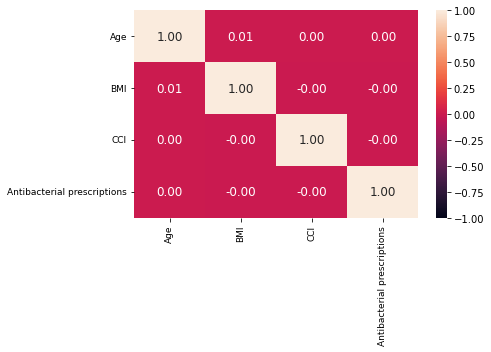

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_otmedia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_otmedia/corr_otmedia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_otmedia = data_otmedia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'otmedia_ab_date', 'ab_type_cat', 'incdt_otmedia_date', 'date', 'period',
                                   'event_otmedia_admitted', 'duration_otmedia_admitted'
                                    ]]

In [37]:
#switch variable otmedia_ab_date into a binary variable
data_otmedia[['ab_binary']] = data_otmedia[['otmedia_ab_date']].where(data_otmedia[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_otmedia_incdt = data_otmedia[data_otmedia['incdt_otmedia_date'] == 0]
data_otmedia_prevl = data_otmedia[data_otmedia['incdt_otmedia_date'] == 1]

#no antibiotics and incident hospital admission
data_otmedia_no_abs_incdt = data_otmedia_incdt[data_otmedia_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_otmedia_abs_incdt = data_otmedia_incdt[data_otmedia_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_otmedia_no_abs_prevl = data_otmedia_prevl[data_otmedia_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_otmedia_abs_prevl = data_otmedia_prevl[data_otmedia_prevl['ab_binary'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_otmedia
# save data
data_otmedia.to_csv('../output/hospitalisation_prediction_otmedia/data_otmedia.csv')

Stored 'data_otmedia' (DataFrame)


## 5- cox modelling for hospital admissions

In [39]:
#prep data for building cox model
data_otmedia_no_abs_incdt_enc = cox_data_prep(data_otmedia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt_enc)

#build cox model
cph_otmedia_no_abs_incdt, prob_pred_no_abs_incdt_dev, prob_pred_no_abs_incdt_val = cox_model_build('otmedia', 'no_abs_incdt', data_otmedia_incdt)

#make a table and figures of probabilities and predictions (deciles)
prob_pred_enc_lr_rf_incdt = make_prob_pred_tables_figs('otmedia', 'no_abs_incdt', cph_otmedia_no_abs_incdt, prob_pred_no_abs_incdt_dev, prob_pred_no_abs_incdt_val, data_otmedia_abs_incdt)

#calculate c-statistics
cox_output(cph_otmedia_no_abs_incdt, 'otmedia', 'no_abs_incdt', prob_pred_no_abs_incdt_dev, prob_pred_no_abs_incdt_val, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')

<lifelines.CoxPHFitter: fitted with 123540 total observations, 122720 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 123540
number of events observed = 820
   partial log-likelihood = -9599.33
         time fit was run = 2023-06-08 08:26:28 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.11       1.12       0.11            -0.10             0.32                 0.91                 1.38
CCI_cat[T.medium]         0.09       1.09       0.12            -0.14             0.32                 0.87                 1.37
CCI_cat[T.high]          -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.28
CCI_cat[T.very_high]      0.15       1.16       0.12            -0.09             0.39                 0.91                 1.47
age_cat[T.25_34]          0.17       1.19       0.13            -0.08             0.42                 0.92                 1.53
age_cat[T.35_44]         -0.02       0.98       0.13            -0.28             0.25                 0.76                 1.28
age_cat[T.45_54]          0.03       1.04       0.13            -0.23             0.30                 0.80                 1.34
age_cat[T.55_64]          0.02       1.02       0.13            -0.24             0.28                 0.78                 1.32
age_cat[T.65_74]          0.02       1.02       0.13            -0.24             0.28                 0.79                 1.33
age_cat[T.75_more]        0.14       1.14       0.13            -0.12             0.39                 0.89                 1.48
antibacterial_brit        0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]          0.11       1.12       0.13            -0.15             0.38                 0.86                 1.46
bmi_cat[T.overweight]     0.01       1.01       0.17            -0.31             0.34                 0.73                 1.40
bmi_cat[T.underweight]   -0.00       1.00       0.24            -0.47             0.46                 0.63                 1.58
bmi_cat[T.unknown]        0.08       1.08       0.14            -0.21             0.36                 0.81                 1.43
ethnicity[T.other]        0.16       1.18       0.18            -0.19             0.52                 0.82                 1.69
ethnicity[T.unknown]      0.15       1.16       0.15            -0.15             0.44                 0.86                 1.56
ethnicity[T.white]        0.11       1.11       0.14            -0.17             0.38                 0.84                 1.47
flu_vaccine[T.yes]       -0.07       0.93       0.12            -0.31             0.16                 0.73                 1.17
imd[T.medium]            -0.01       0.99       0.12            -0.24             0.21                 0.79                 1.24
imd[T.unaffluent]         0.12       1.13       0.11            -0.10             0.34                 0.90                 1.40
imd[T.unknown]            0.09       1.10       0.17            -0.25             0.44                 0.78                 1.55
imd[T.very_affluent]     -0.01       0.99       0.12            -0.23             0.22                 0.79                 1.24
imd[T.very_unaffluent]    0.04       1.04       0.11            -0.18             0.27                 0.83                 1.30
region[T.east_midlands]  -0.19       0.83       0.15            -0.48             0.10                 0.62                 1.11
region[T.london]         -0.28       0.76       0.13            -0.53            -0.03                 0.59     

13031


In [40]:
#prep data for building cox model
data_otmedia_no_abs_prevl_enc = cox_data_prep(data_otmedia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl_enc)

#build cox model
cph_otmedia_no_abs_prevl, prob_pred_no_abs_prevl_dev, prob_pred_no_abs_prevl_val = cox_model_build('otmedia', 'no_abs_prevl', data_otmedia_prevl)

#make a table and figures of probabilities and predictions (deciles)
prob_pred_enc_lr_rf_prevl = make_prob_pred_tables_figs('otmedia', 'no_abs_prevl', cph_otmedia_no_abs_prevl, prob_pred_no_abs_prevl_dev, prob_pred_no_abs_prevl_val, data_otmedia_abs_prevl)

#calculate c-statistics
cox_output(cph_otmedia_no_abs_prevl, 'otmedia', 'no_abs_prevl', prob_pred_no_abs_prevl_dev, prob_pred_no_abs_prevl_val, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')

<lifelines.CoxPHFitter: fitted with 13784 total observations, 13692 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 13784
number of events observed = 92
   partial log-likelihood = -857.54
         time fit was run = 2023-06-08 08:26:33 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.74       0.48       0.33            -1.39            -0.10                 0.25                 0.91
CCI_cat[T.medium]         0.05       1.05       0.31            -0.56             0.66                 0.57                 1.93
CCI_cat[T.high]          -0.35       0.70       0.43            -1.19             0.48                 0.30                 1.61
CCI_cat[T.very_high]      0.23       1.25       0.32            -0.39             0.84                 0.68                 2.33
age_cat[T.25_34]          0.36       1.43       0.37            -0.38             1.09                 0.69                 2.97
age_cat[T.35_44]         -0.35       0.70       0.44            -1.22             0.52                 0.30                 1.67
age_cat[T.45_54]          0.32       1.38       0.38            -0.42             1.06                 0.66                 2.89
age_cat[T.55_64]         -0.12       0.89       0.42            -0.94             0.70                 0.39                 2.01
age_cat[T.65_74]         -0.06       0.94       0.41            -0.86             0.74                 0.42                 2.11
age_cat[T.75_more]        0.05       1.05       0.40            -0.74             0.84                 0.48                 2.31
antibacterial_brit        0.03       1.03       0.07            -0.11             0.18                 0.90                 1.19
bmi_cat[T.obese]         -0.73       0.48       0.30            -1.32            -0.14                 0.27                 0.87
bmi_cat[T.overweight]    -0.71       0.49       0.41            -1.51             0.10                 0.22                 1.10
bmi_cat[T.underweight]   -0.65       0.52       0.63            -1.90             0.59                 0.15                 1.80
bmi_cat[T.unknown]       -0.87       0.42       0.35            -1.55            -0.19                 0.21                 0.83
ethnicity[T.other]       -0.11       0.90       0.52            -1.12             0.91                 0.33                 2.49
ethnicity[T.unknown]     -0.19       0.82       0.41            -1.01             0.62                 0.37                 1.86
ethnicity[T.white]       -0.14       0.87       0.38            -0.89             0.60                 0.41                 1.83
flu_vaccine[T.yes]       -0.27       0.76       0.39            -1.04             0.50                 0.35                 1.65
imd[T.medium]             0.40       1.50       0.36            -0.30             1.10                 0.74                 3.01
imd[T.unaffluent]         0.54       1.72       0.35            -0.14             1.23                 0.87                 3.41
imd[T.unknown]           -0.09       0.91       0.64            -1.35             1.16                 0.26                 3.20
imd[T.very_affluent]      0.09       1.10       0.38            -0.65             0.84                 0.52                 2.31
imd[T.very_unaffluent]    0.28       1.33       0.36            -0.43             1.00                 0.65                 2.72
region[T.east_midlands]  -0.37       0.69       0.43            -1.22             0.49                 0.30                 1.63
region[T.london]         -0.42       0.66       0.37            -1.14             0.31                 0.32          

13044


## 6- Logistic modelling for prescribing antibiotic

### 6-1- incident otmedia

LR coefficients:
                           lr_coef
bins_(0.00755, 0.00817] -2.255615
bins_(0.00817, 0.0132]  -2.262711
bins_(0.00653, 0.00681] -2.267984
bins_(0.00627, 0.00653] -2.293554
bins_(0.00569, 0.00599] -2.310198
bins_(0.00531, 0.00569] -2.311257
bins_(0.00714, 0.00755] -2.317546
bins_(0.00681, 0.00714] -2.329931
bins_(0.00599, 0.00627] -2.353149
bins_(0.00227, 0.00531] -2.420166

RF parameters after grid search: RandomForestClassifier(max_depth=20, max_leaf_nodes=30, n_estimators=200)

RF feature importance:
                           rf_coef
bins_(0.00227, 0.00531]  0.319289
bins_(0.00755, 0.00817]  0.121679
bins_(0.00599, 0.00627]  0.100846
bins_(0.00817, 0.0132]   0.097231
bins_(0.00653, 0.00681]  0.089470
bins_(0.00681, 0.00714]  0.060766
bins_(0.00531, 0.00569]  0.056592
bins_(0.00714, 0.00755]  0.054397
bins_(0.00627, 0.00653]  0.053941
bins_(0.00569, 0.00599]  0.045788

LR AUROC with development and validation data: 0.51230 and 0.51608
RF AUROC with development and val

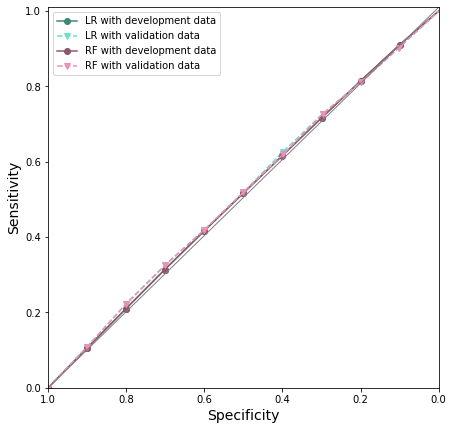

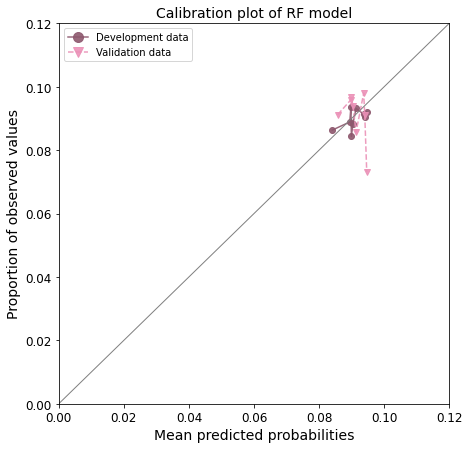

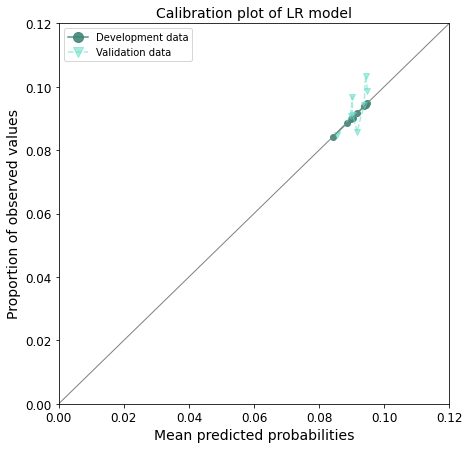

In [41]:
#build lr model with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_otmedia_incdt_dev_y, data_otmedia_incdt_val_y = build_lr_rf_model_with_risk_deciles('otmedia', 'incdt', prob_pred_enc_lr_rf_incdt)
#evaluate lr model
lr_cis = lr_roc_ci('otmedia', 'incdt', data_otmedia_incdt_dev_y, data_otmedia_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr calibration
lr_calibration('otmedia', 'incdt', data_otmedia_incdt_dev_y, data_otmedia_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)

### 6-2- prevalent otmedia

LR coefficients:
                                           lr_coef
bins_(0.00548, 0.00651]                 -1.745239
bins_(0.00947, 0.0124]                  -1.804498
bins_(0.00313, 0.00388]                 -2.031432
bins_(0.00651, 0.00778]                 -2.211018
bins_(0.00235, 0.00313]                 -2.277267
bins_(0.00388, 0.00465]                 -2.277267
bins_(0.00465, 0.00548]                 -2.302585
bins_(0.0124, 0.0671]                   -2.847812
bins_(0.00778, 0.00947]                 -3.044522
bins_(-0.00031999999999999997, 0.00235] -3.597312

RF parameters after grid search: RandomForestClassifier(max_depth=20, max_leaf_nodes=30, n_estimators=200)

RF feature importance:
                                           rf_coef
bins_(-0.00031999999999999997, 0.00235]  0.192586
bins_(0.00548, 0.00651]                  0.171301
bins_(0.00947, 0.0124]                   0.158598
bins_(0.00778, 0.00947]                  0.120188
bins_(0.00313, 0.00388]                  0.082000

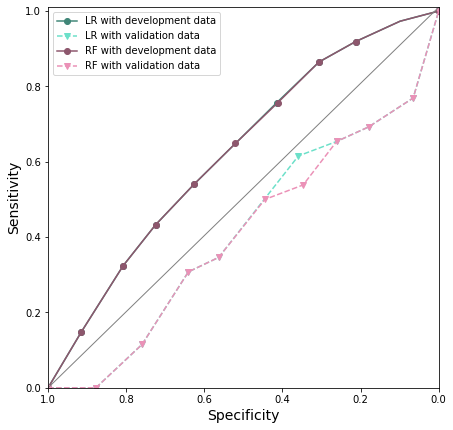

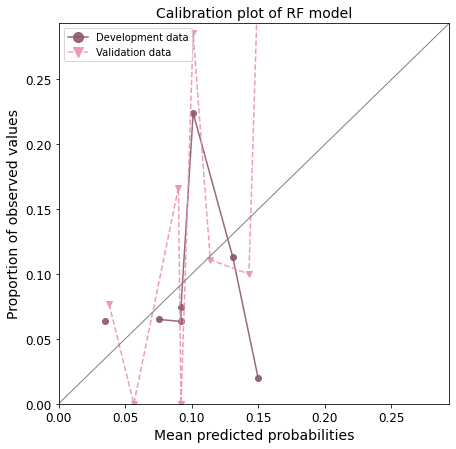

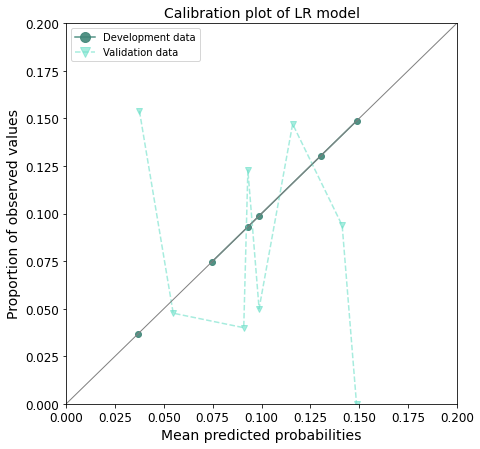

In [42]:
#build lr model with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_otmedia_prevl_dev_y, data_otmedia_prevl_val_y = build_lr_rf_model_with_risk_deciles('otmedia', 'prevl', prob_pred_enc_lr_rf_prevl)
#evaluate lr model
lr_cis = lr_roc_ci('otmedia', 'prevl', data_otmedia_prevl_dev_y, data_otmedia_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr calibration
lr_calibration('otmedia', 'prevl', data_otmedia_prevl_dev_y, data_otmedia_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)